# **CPE 019 - Final Project (Notebook)**

In [46]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image

base_dir = r"C:\Users\Angelo\Downloads\Animals and Plants Classifier.v1i.folder"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [48]:
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(base_dir, 'valid'), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [49]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [50]:
epochs = 10
best_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(valid_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), "best_model_classifier.pth")

Epoch 1/10 - Train Loss: 0.6549 - Train Acc: 0.5857 - Val Acc: 0.8000
Epoch 2/10 - Train Loss: 0.4734 - Train Acc: 0.9143 - Val Acc: 0.9250
Epoch 3/10 - Train Loss: 0.4031 - Train Acc: 0.9071 - Val Acc: 0.9500
Epoch 4/10 - Train Loss: 0.2997 - Train Acc: 0.9357 - Val Acc: 0.9750
Epoch 5/10 - Train Loss: 0.1978 - Train Acc: 0.9786 - Val Acc: 0.9750
Epoch 6/10 - Train Loss: 0.1568 - Train Acc: 0.9786 - Val Acc: 0.9750
Epoch 7/10 - Train Loss: 0.1343 - Train Acc: 0.9714 - Val Acc: 0.9750
Epoch 8/10 - Train Loss: 0.0775 - Train Acc: 1.0000 - Val Acc: 1.0000
Epoch 9/10 - Train Loss: 0.0866 - Train Acc: 0.9786 - Val Acc: 1.0000
Epoch 10/10 - Train Loss: 0.0560 - Train Acc: 0.9929 - Val Acc: 1.0000


In [51]:
model.load_state_dict(torch.load("best_model_classifier.pth"))
model.eval()

test_corrects = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 1.0000


C:\Users\Angelo\AppData\Local\Temp\ipykernel_25392\637906944.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_classifier.pth"

In [52]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")

    image_tensor = test_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()
        class_name = train_dataset.classes[class_idx]

    plt.imshow(image)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

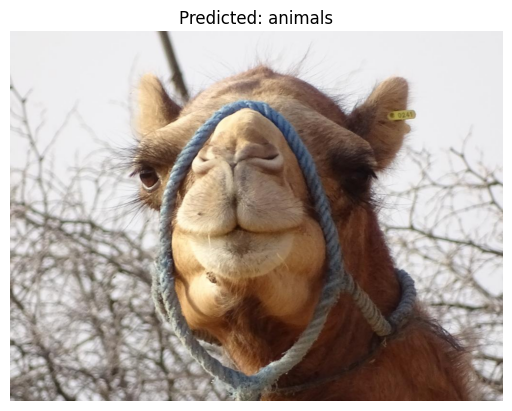

In [53]:
predict_image(r"C:\Users\Angelo\Downloads\Animals and Plants Classifier.v1i.folder\test\animals\animals-44-_jpg.rf.c57ab516a7ca8152cc457bd0988f0d97.jpg")

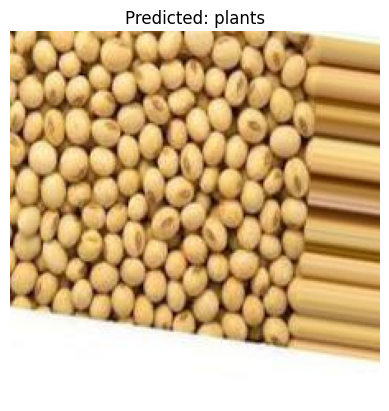

In [54]:
predict_image(r"C:\Users\Angelo\Downloads\Animals and Plants Classifier.v1i.folder\test\plants\plants-12-_jpg.rf.f0135eeabc6da9ca9798b18b06cd09c7.jpg")

In [55]:
torch.save(model.state_dict(), r"C:\Users\Angelo\Desktop\CPE 019 Final Project\best_model_classifier.pth")